# Exploring States

Our couples data actually has a column that decodes the state in which the couple was found. While this notebook aims to classify the highest earnings states for young couples, it currently as inconclusive results.

Models being utilized
* OLS
* OLS w/ K-Fold Cross Validation
* Lasso w/ K-Fold Cross Validation

# Loading Packages

In [26]:
# Set Up

# Graphing
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14,14)
import seaborn as sns

# Tools
import pandas as pd
import numpy as np


# These lines make warnings look nicer
import warnings
warnings.simplefilter('ignore', FutureWarning)


# Regression Packages
import statsmodels.api as sm
import sklearn.linear_model as lm
import sklearn


In [27]:
sample = pd.read_csv('../data/sample.csv')
sample.head()

,KIDCOUNT,boy1st,boy2nd,boys2,girls2,samesex,morekids,blackm,hispm,whitem,...,agem,aged,weeksm,weeksd,wagem,waged,expm,expd,st,rv
0,2,1,0,0,0,0,0,0,0,1,...,27,35,0,16,NaN,72.078303,9,17,63,0.432150
1,2,0,1,0,0,0,0,0,0,1,...,30,28,30,32,25.954494,26.818263,17,13,63,0.378113
2,2,1,0,0,0,0,0,0,0,1,...,27,30,0,52,NaN,24.285571,9,11,63,0.867049
3,2,1,0,0,0,0,0,1,0,0,...,35,36,0,52,NaN,35.210337,15,11,63,0.046637
4,2,0,0,0,1,1,0,0,0,1,...,30,34,22,40,15.608967,18.148450,10,10,63,0.053762


# Data Cleaning and Wrangling 

Let's first create the dummies for the state variable so we can actually observe our data at the state-level:
* st is encoded as a 2-digit state of residence where the 1st digit represents division
* there are 51 unqiue values representing 50 US states + DC

In [28]:
len(sample['st'].value_counts())

51

Model 1 has 101 regressors and a constant

$$ log(wage_d) = \beta_0 + \beta_1 age_{dad} + \beta_{2-52}<state dummies> + \beta_{53-103} <age_{dad}*state> + \epsilon_i$$

Let's create the dataframe needed to run the model by iterating through unique values of 'ST' and creating our dummy column respectively. 

In [29]:
sample['logwaged'] = np.log(sample['waged'])

In [30]:
# Dictionary deciphering the encoded column

census_cps = {
    63: 'Alabama',
    94: 'Alaska',
    86: 'Arizona',
    71: 'Arkansas',
    93: 'California',
    84: 'Colorado',
    16: 'Connecticut',
    51: 'Delaware',
    53: 'District of Columnbia',
    59: 'Florida',
    58: 'Georgia', 
    95: 'Hawaii', 82: 'Idaho',
    33: 'Illinois', 32: 'Indiana', 42: 'Iowa',
    47: 'Kansas', 61: 'Kentucky', 72: 'Louisiana', 11: 'Maine',
    52: 'Maryland',
    14: 'Massachusetts', 34: 'Michigan',
    41: 'Minnesota',
    64: 'Mississippi',
    43: 'Missouri',
    81: 'Montana',
    46: 'Nebraska',
    88: 'Nevada',
    12: 'New Hampshire', 22: 'New Jersey',
    85: 'New Mexico',
    21: 'New York',
    56: 'North Carolina', 44: 'North Dakota', 31: 'Ohio',
    73: 'Oklahoma',
    92: 'Oregon',
    23: 'Pennsylvania', 15: 'Rhode Island', 57: 'South Carolina', 
    45: 'South Dakota', 62: 'Tennessee',
    74: 'Texas',
    87: 'Utah',
    13:'Vermont',
    54: 'Virginia',
    91: 'Washington',
    55: 'West Virginia' ,35: 'Wisconsin',
    83: 'Wyoming'}


for state in sample['st'].unique():
    k = state
    
    #index to dictionary and use that to create the column name
    sample[census_cps[state]] = (sample['st'] == state).astype(int)
    
    #interaction terms
    sample[census_cps[state] + str(k)] = sample['aged'] * (sample['st'] == state).astype(int)

The following dataframe has 103 columns, 1 of which represent our variable of interest _logwaged_ as well as the 102 covariates representing a state dummy and a state dummy's interaction with age

In [31]:
sample.iloc[:, 41:].head()

,logwaged,Alabama,Alabama63,Alaska,Alaska94,Arizona,Arizona86,Arkansas,Arkansas71,California,...,Utah,Utah87,Wyoming,Wyoming83,Hawaii,Hawaii95,Oregon,Oregon92,Washington,Washington91
0,4.277753,1,35,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.289083,1,28,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.189882,1,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.561340,1,36,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.898585,1,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Splitting the data accordingly:

### Train/Estimation
* father
* exactly 16 years of education
* rv < 0.75
* n = 20923


### Test/Holdout
* father
* exactly 16 years of education
* rv >= 0.75
* n = 7065

In [32]:
train = sample[(sample['educd'] == 16) & (sample['rv'] < 0.75)]
test = sample[(sample['educd'] == 16) & (sample['rv'] >= 0.75)]

In [33]:
# For future use
summary_table = pd.DataFrame(columns = ["OLS", "Lasso/L1 Norm"], 
                             index = ["RMSE", "RSS"])

We should have 103 covariates plus the constant because we have to include the interaction effect of all states AND DC which adds an extra two features of 'DC' and 'DC and age''s interactionaction

In [34]:
#The 42nd column is when our dummy matrix for interactions begin
X_train = sm.add_constant(pd.concat([train['aged'], train.iloc[:, 42:]], axis = 1))
Y_train = train['logwaged']

X_train.head()

,const,aged,Alabama,Alabama63,Alaska,Alaska94,Arizona,Arizona86,Arkansas,Arkansas71,...,Utah,Utah87,Wyoming,Wyoming83,Hawaii,Hawaii95,Oregon,Oregon92,Washington,Washington91
6,1.0,28,1,28,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,1.0,38,1,38,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,1.0,39,1,39,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,1.0,32,1,32,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,1.0,35,1,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Initial OLS
ols = sm.OLS(Y_train, X_train)
ols = ols.fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logwaged   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     13.37
Date:                Thu, 28 May 2020   Prob (F-statistic):          1.04e-209
Time:                        12:36:40   Log-Likelihood:                -16005.
No. Observations:               20923   AIC:                         3.221e+04
Df Residuals:                   20821   BIC:                         3.302e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.4404      0.056     43.240      0.000       2.330       2.551
aged                        0.0281      0.002     16.626      0.000       0.025       0.031
Alabama                     0.2508      0.276      0.908      0.364      -0.291       0.792
Alabama63                  -0.0064      0.008     -0.778      0.437      -0.023       0.010
Alaska                     -0.3043      0.748     -0.407      0.684      -1.771       1.162
Alaska94                    0.0197      0.022      0.876      0.381      -0.024       0.064
Arizona                     0.0570      0.290      0.197      0.844      -0.511       0.625
Arizona86                  -0.0005      0.009     -0.054      0.957      -0.017       0.016
Arkansas                   -0.3486      0.344     -1.012      0.311      -1.024       0.326
Arkansas71                  0.0086      0.010      0.831      0.406      -0.012       0.029
California                  0.1304      0.126      1.032      0.302      -0.117       0.378
California93               -0.0002      0.004     -0.061      0.951      -0.007       0.007
Colorado                    0.2235      0.259      0.862      0.389      -0.285       0.732
Colorado84                 -0.0038      0.008     -0.480      0.631      -0.019       0.012
Connecticut                -0.2266      0.313     -0.725      0.469      -0.839       0.386
Connecticut16               0.0125      0.009      1.347      0.178      -0.006       0.031
Maine                      -0.5121      0.486     -1.054      0.292      -1.465       0.440
Maine11                     0.0114      0.015      0.780      0.435      -0.017       0.040
Massachusetts              -0.1587      0.230     -0.690      0.490      -0.609       0.292
Massachusetts14             0.0085      0.007      1.249      0.212      -0.005       0.022
New Hampshire               0.2726      0.460      0.592      0.554      -0.630       1.175
New Hampshire12            -0.0066      0.014     -0.477      0.633      -0.034       0.021
Rhode Island                0.1042      0.469      0.222      0.824      -0.815       1.024
Rhode Island15             -0.0003      0.014     -0.022      0.982      -0.028       0.027
Vermont                    -0.3977      0.763     -0.521      0.602      -1.893       1.097
Vermont13                   0.0082      0.023      0.364      0.716      -0.036       0.052
New Jersey                  0.3840      0.185      2.071      0.038       0.021       0.747
New Jersey22               -0.0033      0.005     -0.603      0.546      -0.014       0.007
New York                    0.2922      0.149      1.962      0.050       0.000       0.584
New York21                 -0.0035      0.004     -0.803      0.422      -0.012       0.005
Pennsylvania               -0.1605      0.169  

## Findings from the baseline model

* $P(F_{Statistic})$ is nearly 0 so this indicates this is a reasonable analysis

Let's find out what the baseline model predicts for the average hourly wage of people age 26 and 35.

In [36]:
twenty_six =  X_train[ X_train['aged'] == 26]
thirty_five =  X_train[ X_train['aged'] == 35]

#The following two lines below stores the logwage points of those aged 26 and 35
ols_26 = ols.predict(twenty_six)
ols_35 = ols.predict(thirty_five)

display(np.mean(np.exp(ols_26)), np.mean(np.exp(ols_35))

SyntaxError: unexpected EOF while parsing (<ipython-input-36-8c5766dce413>, line 8)



# Implementing a Lasso + Cross Validation Model

In order to better understand the most approrpriate number of features, I will implement k-fold cross validation via sklearn's kFold package.

In [37]:
from sklearn.linear_model import LassoCV

# REDEFINING BECAUSE SKLEARN AUTOMATICALLY INCLUDES THE CONSTANT
# WHEN RUNNING OLS

X_train = pd.concat([train['aged'], train.iloc[:, 42:]], axis = 1)
twenty_six =  X_train[X_train['aged'] == 26]
thirty_five =  X_train[X_train['aged'] == 35]

lasso_cv = LassoCV(cv = 5, random_state = 0).fit(X_train, Y_train)

lasso_cv_26 = lasso_cv.predict(twenty_six)
lasso_cv_35 = lasso_cv.predict(thirty_five)

X_train.head()

,aged,Alabama,Alabama63,Alaska,Alaska94,Arizona,Arizona86,Arkansas,Arkansas71,California,...,Utah,Utah87,Wyoming,Wyoming83,Hawaii,Hawaii95,Oregon,Oregon92,Washington,Washington91
6,28,1,28,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,38,1,38,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,39,1,39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,32,1,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,35,1,35,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Best state for men age 26 and 35 according to OLS

In [38]:
# Training Set for Men age 26
train26 =  train[train['aged'] == 26]
X_train26 = pd.concat([train26['aged'], train26.iloc[:, 42:]], axis = 1)
Y_train26 = train26['logwaged']


# Testing Set
test26 =  test[test['aged'] == 26]
X_test26 = pd.concat([test26['aged'], test26.iloc[:, 42:]], axis = 1)
Y_test26 = test26['logwaged']

print(f" The length of train26 is {len(train26)}, the length of test26 is {len(test26)}.")

 The length of train26 is 223, the length of test26 is 62.


In [39]:
# Training Set for Men age 35
train35 =  train[train['aged'] == 35]
X_train35 = pd.concat([train35['aged'], train35.iloc[:, 42:]], axis = 1)
Y_train35 = train35['logwaged']

#Testing Set
test35 =  test[test['aged'] == 35]
X_test35 = pd.concat([test35['aged'], test35.iloc[:, 42:]], axis = 1)
Y_test35 = test35['logwaged']

print(f" The length of train35 is {len(train35)}, the length of test35 is {len(test35)}.")

 The length of train35 is 1978, the length of test35 is 639.


In [44]:
ols26 = sklearn.linear_model.LinearRegression(fit_intercept = True)
ols26 = ols26.fit(X = X_train26, y = Y_train26)

# Looking at the largest value coeffecient is what will tell me the most important state is
X_train26.columns[np.argmax(ols26.coef_)]

'Connecticut'

Interesting! Conneticut seems to be the highest log wage state for 26 year olds according to the OLS model

In [45]:
len(X_train.columns)
X_train.head()

,aged,Alabama,Alabama63,Alaska,Alaska94,Arizona,Arizona86,Arkansas,Arkansas71,California,...,Utah,Utah87,Wyoming,Wyoming83,Hawaii,Hawaii95,Oregon,Oregon92,Washington,Washington91
6,28,1,28,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,38,1,38,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,39,1,39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,32,1,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,35,1,35,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
ols35 = sklearn.linear_model.LinearRegression(fit_intercept = True)
ols35 = ols35.fit(X = X_train35, y = Y_train35)

X_train35.columns[np.argmax(ols35.coef_)]

'Alaska'

While this is what the model says, I'm surprised I'm not seeing something like New York or California. I'm going to want to look into this more.

# Evaluating the models with the test/holdout sample

In [44]:
def rmse(actual_y, predicted_y):
    """
    Args:
        predicted_y: an array of the prediction from the model
        actual_y: an array of the groudtruth label
        
    Returns:
        The root mean square error between the prediction and the groudtruth
        
    """
    difference_squared = (actual_y - predicted_y)**2
    n = len(difference_squared)
    return np.sqrt((1/n) * np.sum(difference_squared))

summary_table

,OLS,Lasso/L1 Norm
RMSE,NaN,NaN
RSS,NaN,NaN


,OLS,Lasso/L1 Norm
RMSE,0.512493,0.068520
RSS,1855.617131,1887.251626


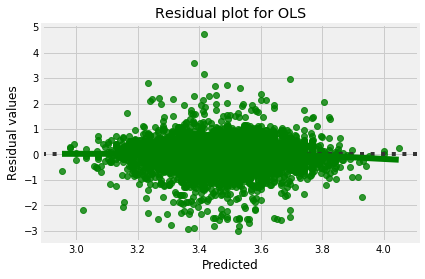

In [51]:
X_test = sm.add_constant(pd.concat([test['aged'], test.iloc[:, 42:]], axis = 1))
Y_test = test['logwaged']


ols_test_error = rmse(Y_test, ols.predict(X_test))
ols_r2 = np.corrcoef(Y_test, ols.predict(X_test))[0,1] ** 2
ols_residual = Y_test - ols.predict(X_test)
ols_rss = np.sum((Y_test - ols.predict(X_test) )**2)

sns.residplot(ols.predict(X_test), ols_residual, lowess=True, color="g")

plt.xlabel("Predicted")
plt.ylabel("Residual values")
plt.title('Residual plot for OLS');


summary_table["OLS"]= [ols_test_error, ols_rss]
summary_table

,OLS,Lasso/L1 Norm
RMSE,0.512493,0.068520
RSS,1855.617131,1887.251626


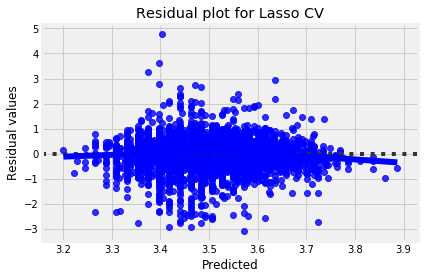

In [52]:
X_test =  pd.concat([test['aged'], test.iloc[:, 42:]], axis = 1)
Y_test = test['logwaged']

lasso_cv_test_error = rmse(pd.Series(Y_test), pd.Series(lasso_cv.predict(X_test)))
lasso_cv_r2 = lasso_cv.score(X_test, Y_test)
lasso_residual = (Y_test - lasso_cv.predict(X_test))
lasso_cv_rss = np.sum(lasso_residual **2 )

sns.residplot(lasso_cv.predict(X_test), lasso_residual, lowess=True, color="b")

plt.xlabel("Predicted")
plt.ylabel("Residual values")
plt.title('Residual plot for Lasso CV');



summary_table["Lasso/L1 Norm"]= [lasso_cv_test_error, lasso_cv_rss]
summary_table

# Accuracy of OLS versus Residuals

The RMSE is significantly lower for the Lasso regression, but when we observe the plots and residual sum of squares we will see that the plots are very identical. 

# Appendix 

_The following is a functions are from UC Berkeley's data science course Data 100 that might be helpful but I'm going to leave in this messy form for now._

In [ ]:

# def compute_CV_error(model, X_train, Y_train):
#     '''
#     Split the training data into 4 subsets.
#     For each subset, 
#         fit a model holding out that subset
#         compute the MSE on that subset (the validation set)
#     You should be fitting 4 models total.
#     Return the average MSE of these 4 folds.

#     Args:
#         model: an sklearn model with fit and predict functions 
#         X_train (data_frame): Training data
#         Y_train (data_frame): Label 

#     Return:
#         the average validation MSE for the 4 splits.
#     '''
#     kf = KFold(n_splits=4)
#     validation_errors = []
    
#     for train_idx, valid_idx in kf.split(X_train):
#         # split the data
#         split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
#         split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

#         # Fit the model on the training split
#         model.fit(split_X_train,split_Y_train)
        
#         # Compute the RMSE on the validation split
#         error = rmse(split_Y_valid,model.predict(split_X_valid))


#         validation_errors.append(error)
        
#     return np.mean(validation_errors)

In [ ]:
# errors = []
# for N in range_of_num_features:
#     print(f"Trying first {N} features")
#     model = lm.LinearRegression()
    
#     # compute the cross validation error
#     error = compute_CV_error(model, X_train.iloc[:, :N], Y_train)
    
#     print("\tRMSE:", error)
#     errors.append(error)

# best_num_features = np.argmin(errors) + 1
# best_err = errors[best_num_features - 1]

# print(f"Best choice, use the first {best_num_features} features")

In [ ]:

# # from sklearn.model_selection import KFold
# # from sklearn.model_selection import cross_val_score

# # linear_model = lm.LinearRegression()
# # linear_model.fit(X_train, Y_train)
# # Y_pred = linear_model.predict(X_train)

# kf = KFold(n_splits = 10)
# kf

# scores = cross_val_score(linear_model, X_train, Y_train, cv=4)

